# Métricas de clasificación

Para poder evaluar el desempeño de un modelo predictivo se deben aplicar medidas que nos comuniquen el rendimiendo del modelo de una manera sistemática. Con estas métricas de desempeño podremos tomar decisiones en la etapa de selección de modelos, en donde queremos seleccionar el modelo que mejor se desempeñe en nuestra tarea. Estas métricas deben ser seleccionadas acorde a la tarea que queremos resolver y el objetivo que queremos alcanzar.

In [1]:
import pandas as pd # Biblioteca de manejo de datos tabulares
import numpy as np # Biblioteca de manejo de datos vectoriales
import sklearn.model_selection # Módulo de selección de modelos de sklearn
import sklearn.svm # Módulo de support vector machines
import sklearn.dummy # Módulo de estimadores al azar
import sklearn.metrics # Módulo de métricas de desempeño
import sklearn.datasets # Módulo de conjuntos de datos de muestra
import collections # Módulo de python con estructuras de datos
import matplotlib.pyplot as plt # Biblioteca de visualización

Utilizaremos un conjunto de datos de cáncer, en donde desde un conjunto de características celulares, buscamos predecir la malignidad del tumor.

In [2]:
breast_cancer = sklearn.datasets.load_breast_cancer()

In [3]:
features = breast_cancer.data

In [4]:
label = breast_cancer.target

Para poder evaluar los desempeños de nuestros modelos de la manera más válida posible, se suele dividir nuestro conjunto de datos un en subconjunto de entrenamiento y uno de prueba. El subconjunto de entrenamiento es el único que utilizaremos para entrenar nuestro modelo. El subconjunto de prueba es independiente al de entrenamiento y con este evaluamos las métricas de desempeño de nuestro modelo.

Para fácilemente realizar esta separación utilizamos la función ``sklearn.model_selection.train_test_split()``

In [5]:
features_train, features_test, label_train, label_test = sklearn.model_selection.train_test_split( # Vamos a guardar todos los subconjuntos que nos devolverá la función en distintas variables
    features, 
    label, 
    test_size=0.33, # Este es el tamaño relativo que tendrá el subconjunto de prueba
    random_state=11, # # Con esto bloqueamos el generador de números aleatorios para tener resultados consistentes
    stratify=label # Conservamos las proporciones entre las clases
)

Mediremos las métricas de desemèño sobre un modelo basado en Support Vector Machines con un kernel lineal.

In [6]:
svc_classifier_linear = sklearn.svm.SVC(kernel="linear", probability=True) # Instanciamos el algoritmo para entrenar un modelo de SVM
svc_classifier_linear.fit(features_train, label_train) # Ajustamos el modelo
svc_classifier_linear_predictions_discrete = svc_classifier_linear.predict(features_test) # Predecimos sobre el subconjunto de prueba

Como modelo de control utilizaremos un modelo que simplemente nos devuelva una etiqueta al azar, respecto la distribución de las etiquetas del conjunto de prueba.

In [7]:
dummy_classifier = sklearn.dummy.DummyClassifier(strategy="stratified", random_state=12)
dummy_classifier.fit(features_train, label_train)
dummy_classifier_predictions_discrete = dummy_classifier.predict(features_test)

## Matriz de confusión

Un grupo de métricas de clasificación se basan en una tabla con un diseño específico que nos permite visualizar el desempeño de un modelo, esta matriz de confusión representa en cada fila las instancias que pertenecen correctamente a cada clase y cada columna representa las instances que el modelo predijo en cada clase o vice-versa.

Esta matriz la podemos construir directamente con la función ``sklearn.metrics.confusion_matrix()``.

In [8]:
sklearn.metrics.confusion_matrix(
    label_test, # Aquí pasamos las clases correctas
    svc_classifier_linear_predictions_discrete # Aquí pasamos las clases predichas por el modelo
)

array([[ 63,   7],
       [  3, 115]])

In [9]:
sklearn.metrics.confusion_matrix(label_test, dummy_classifier_predictions_discrete)

array([[26, 44],
       [42, 76]])

También podemos visualizar como mapa de calor la matriz de confusión con ``sklearn.metrics.plot_confusion_matrix()``

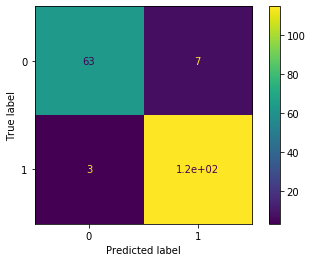

In [50]:
sklearn.metrics.plot_confusion_matrix(
    svc_classifier_linear, features_test, label_test,
)

Para poder facilitarnos el manejo de la matriz de confusión de manera más simple crearemos una función que nos devolverá un objeto al cual podemos acceder a cada elemento de la matriz de confusión por su nombre.

In [51]:
def confusion_matrix(cm):
    """ Esta función recibe una matriz de confusión creada con sklearn y devuelve una namedtouple para acceder a sus
    elementos por su nombre.
    """
    # Se puede observar acá en qué celda se encuentra cada elemento en nuestra matriz de confusión.
    true_negatives = cm[0,0] # Los verdaderos negativos se encuentran arriba a la izquierda.
    false_negatives = cm[0,1]
    false_positives = cm[1,0]
    true_positives = cm[1,1]
    ConfusionMatrix = collections.namedtuple("ConfusionMatrix", ["true_negatives", "false_negatives", "false_positives", "true_positives"])
    return ConfusionMatrix(true_negatives, false_negatives, false_positives, true_positives)

Transformamos las matrices de confusión generadas por sklearn hacia la representación creada anteriormente.

In [11]:
svc_classifier_linear_confusion_matrix = confusion_matrix(sklearn.metrics.confusion_matrix(label_test, svc_classifier_linear_predictions_discrete))
svc_classifier_linear_confusion_matrix

ConfusionMatrix(true_negatives=63, false_negatives=7, false_positives=3, true_positives=115)

In [12]:
dummy_classifier_confusion_matrix = confusion_matrix(sklearn.metrics.confusion_matrix(label_test, dummy_classifier_predictions_discrete))
dummy_classifier_confusion_matrix

ConfusionMatrix(true_negatives=26, false_negatives=44, false_positives=42, true_positives=76)

## Accuracy

La métrica de accuracy es una medida no dependiente de la clase que nos resume completamente nuestra matriz de confusión. Esta métrica se usa poco porque es muy sensible a casos desbalanceados. Esta métrica se calcula de esta manera:

$$
Accuracy = \frac{TP + TN}{TP + TN + FP + FN},
$$

donde $TP =$ Verdaderos positivos, $TN =$ Verdaderos negativos, $FP =$ Falsos positivos, $FN =$ Falsos negativos

In [52]:
def accuracy(cm):
    """Recibe una matriz de confusión y retorna la métrica de Accuracy"""
    return (cm.true_positives + cm.true_negatives) / (cm.true_positives + cm.true_negatives + cm.false_positives + cm.false_negatives) 

Podemos ver que respecto al accuracy, el modelo basado en Support Vector Machines funciona mejor que el de control.

In [53]:
accuracy(svc_classifier_linear_confusion_matrix)

0.9468085106382979

In [54]:
accuracy(dummy_classifier_confusion_matrix)

0.5425531914893617

## Precision

En general, la métrica de precision es una métrica dependiente de la clase, que se define como:

$$
Precision = \frac{|elementos\ relevantes|\cap|elementos\ recogidos|}{|elementos\ recogidos|}
$$,

por lo que se puede calcular para cualquier clase, pero la variante más usada, y la cual se considera como precision por defecto se define como:

$$
Precision = \frac{TP}{TP + FP}
$$

In [55]:
def precision(cm):
    """Recibe una matriz de confusión y retorna la métrica de Precision"""
    return cm.true_positives / (cm.true_positives + cm.false_positives)

El modelo basado en Support Vector Machines, también se comporta mejor según esta métrica.

In [19]:
precision(svc_classifier_linear_confusion_matrix)

0.9745762711864406

In [20]:
precision(dummy_classifier_confusion_matrix)

0.6440677966101694

## Recall

En general, la métrica de recall es una métrica dependiente de la clase, que se define como:

$$
Recall = \frac{|elementos\ relevantes|\cap|elementos\ recogidos|}{|elementos\ relevantes|}
$$,

por lo que se puede calcular para cualquier clase, pero la variante más usada, y la cual se considera como recall por defecto se define como:

$$
Recall = \frac{TP}{TP + FN}
$$

In [56]:
def recall(cm):
    """Recibe una matriz de confusión y retorna la métrica de Recall"""
    return cm.true_positives / (cm.false_negatives + cm.true_positives)

El modelo basado en Support Vector Machines, también se comporta mejor según esta métrica.

In [21]:
recall(svc_classifier_linear_confusion_matrix)

0.9426229508196722

In [22]:
recall(dummy_classifier_confusion_matrix)

0.6333333333333333

## F-Score

La métrica F-Score es una medida que busca obtener un resumen del rendimiento de un modelo en una clase específica respecto a sus medidas de precision y recall.

En general, esta métrica se define como:

$$
F_\beta = (1 + \beta^2) \cdot \frac{\mathrm{Precision} \cdot \mathrm{Recall}}{(\beta^2 \cdot \mathrm{Precision}) + \mathrm{Recall}},
$$

donde $\beta$ es un parámetro libre que busca ponderar la importancia del recall, donde el recall es considerado $\beta$ veces más importante que la precision.

Tradicionalmente se utiliza el F1-Score en donde $\beta = 1$ y se define como:

$$
F_1 = 2 \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{\mathrm{precision} + \mathrm{recall}} 
$$

In [58]:
def f_beta(cm, beta=1):
    """Recibe una matriz de confusión y retorna la métrica de F_beta-Score"""
    current_precision = precision(cm)
    current_recall = recall(cm)
    return (1 + beta**2) * ((current_precision * current_recall) / ((beta**2 * current_precision) + current_recall))

El modelo basado en Support Vector Machines, también se comporta mejor según esta métrica.

In [23]:
f_beta(svc_classifier_linear_confusion_matrix)

0.9583333333333334

In [24]:
f_beta(dummy_classifier_confusion_matrix)

0.6386554621848739

## Classification report

sklearn nos probee de una función que nos resume el rendimiento de nuestro modelo con todas las métricas definidas anteriormente. Además nos ofrece métricas que agregan los rendimientos de cada clase con distintas técnicas de agregación:

* Promedio ponderado: La medida de cada clase se pondera por el tamaño de la clase y luego se suman
* Promedio macro: La medida de cada clase simplemente se promedia.

Este reporte se implementa en la función ``sklearn.metrics.classification_report()``

In [25]:
print(sklearn.metrics.classification_report(label_test, svc_classifier_linear_predictions_discrete))

              precision    recall  f1-score   support

           0       0.95      0.90      0.93        70
           1       0.94      0.97      0.96       118

    accuracy                           0.95       188
   macro avg       0.95      0.94      0.94       188
weighted avg       0.95      0.95      0.95       188



In [26]:
print(sklearn.metrics.classification_report(label_test, dummy_classifier_predictions_discrete))

              precision    recall  f1-score   support

           0       0.38      0.37      0.38        70
           1       0.63      0.64      0.64       118

    accuracy                           0.54       188
   macro avg       0.51      0.51      0.51       188
weighted avg       0.54      0.54      0.54       188



## False positive rate

Esta es una métrica poco utilizada de manera aislada, pero es importante para poder calcular el área bajo la curva ROC. Esta métrica se define como:

$$
FPR=\frac{\mathrm{FP}}{\mathrm{FP} + \mathrm{TN}}
$$

In [59]:
def false_positive_rate(cm):
    """Recibe una matriz de confusión y retorna la métrica de False Positive Rate"""
    return cm.false_positives / (cm.false_positives + cm.true_negatives)

In [30]:
false_positive_rate(svc_classifier_linear_confusion_matrix)

0.045454545454545456

In [31]:
false_positive_rate(dummy_classifier_confusion_matrix)

0.6176470588235294

## Area under the receiver operating characteristic curve

La curva receiver operating characteristic (ROC) es una representación gráfica que ilustra la capacidad predictiva de un clasificador binario a medida que su umbral de decisión es variado.

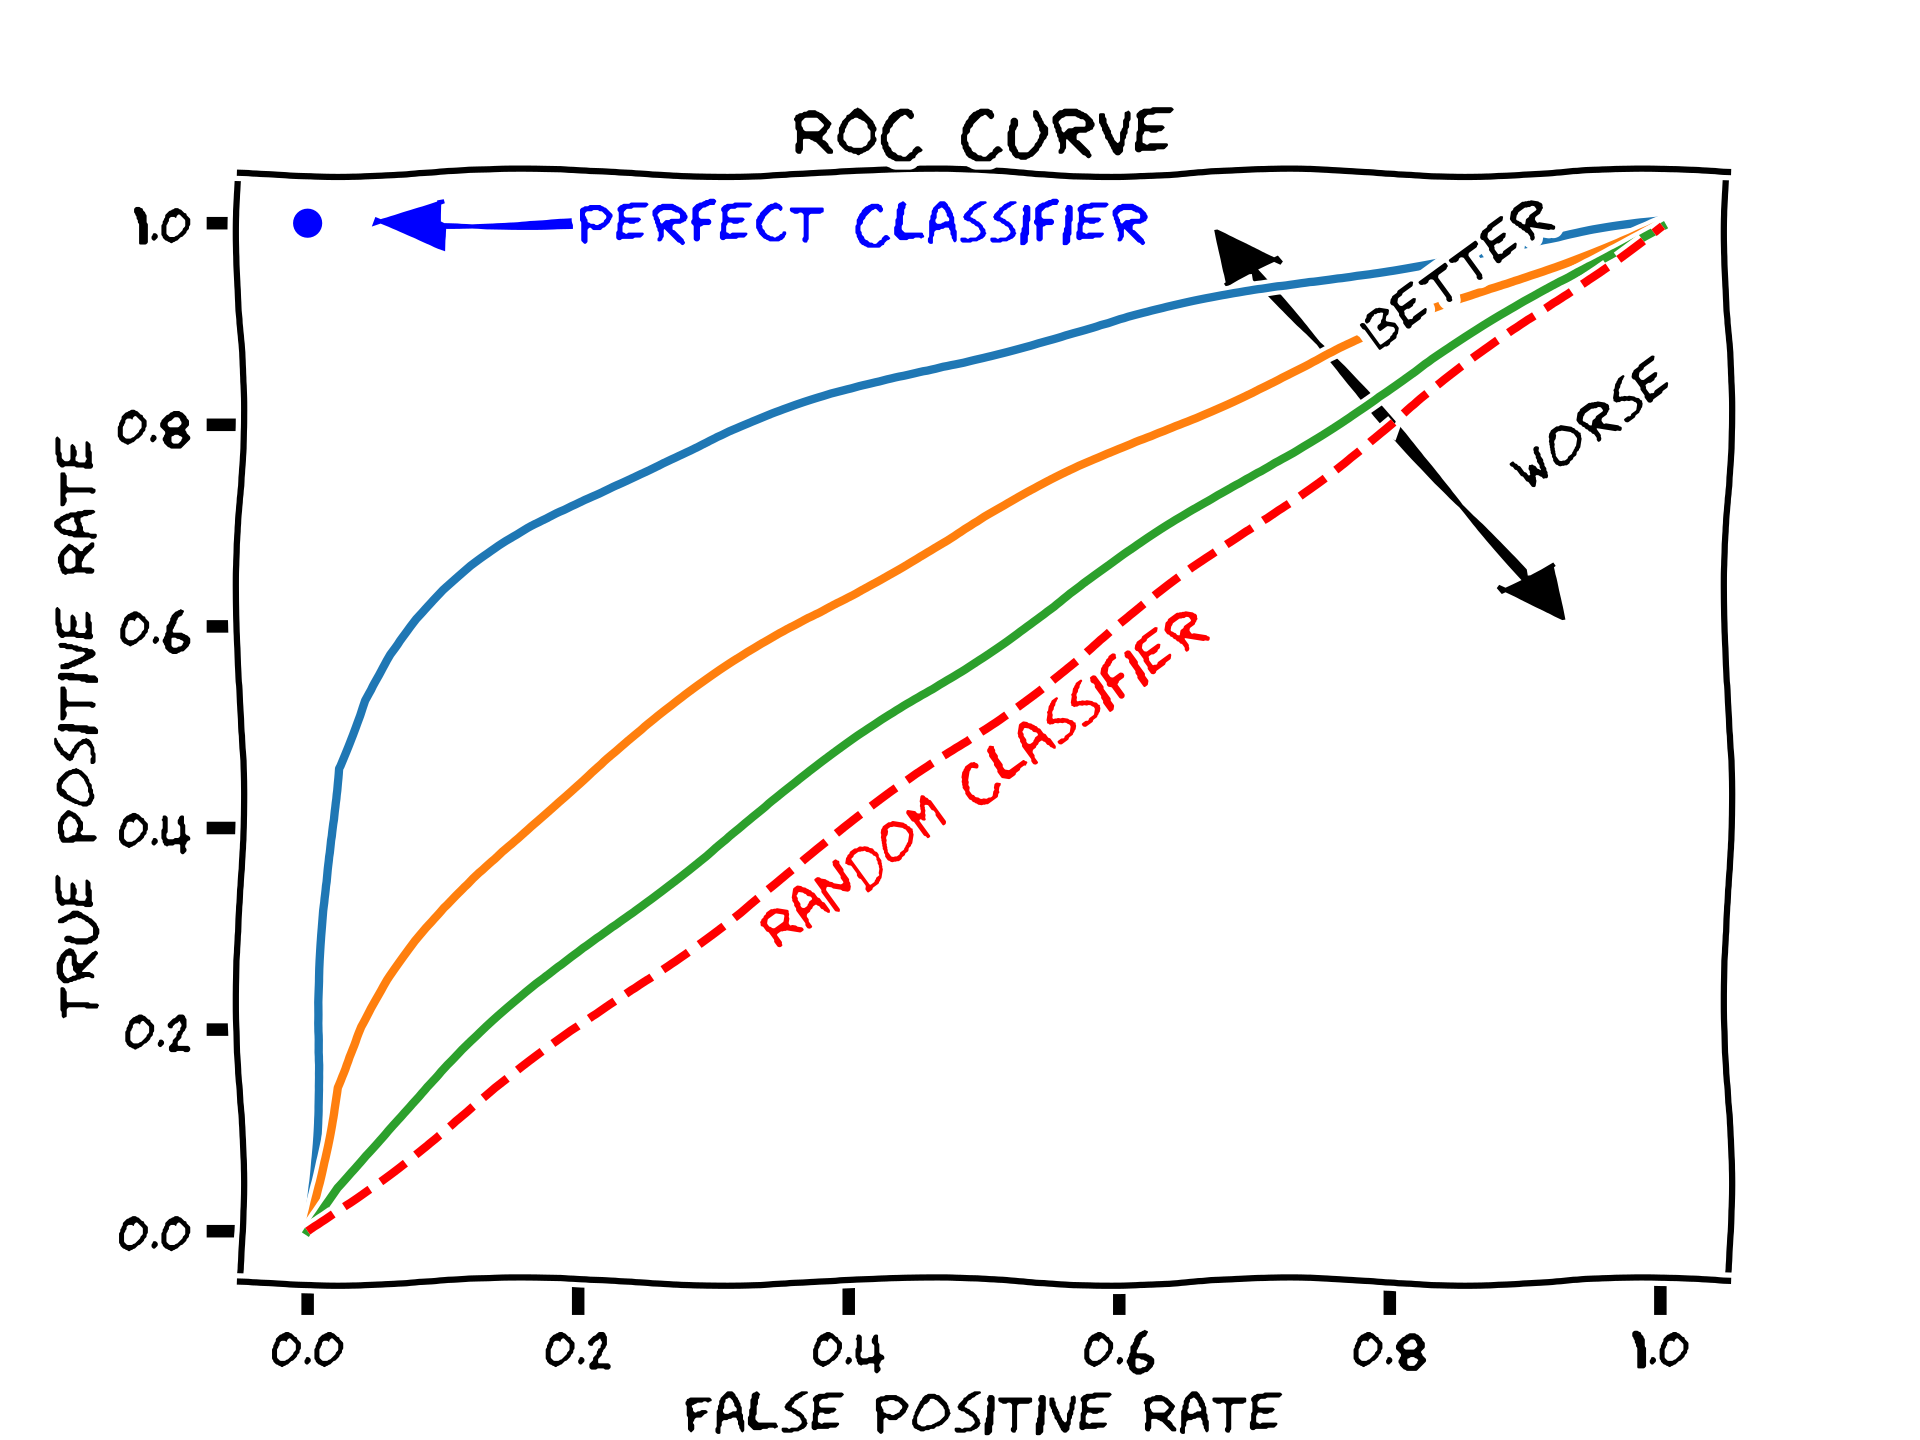

Y una métrica que se deriva de esta representación es el área bajo la curva ROC (AUC). Esta métrica es altamente utilizada y nos comunica la probabilidad que un clasificador posicionará una instancia positiva al azar más alto que una instancia negativa al azar (asumiendo que las instancias positivas se posicionan más alto que las negativas).

Para poder calcular la curva ROC debemos calcular las métricas de desempeño de nuestro modelo al variar el umbral de decision con un barrido de valores.

In [28]:
def recall_at_threshold(true, predicted_proba, threshold=0.5):
    """Recibe las clases correctas, las probabilidades predichas por un modelo y un umbral y retorna
    la métrica de recall asociada a ese umbral.
    """
    return recall(
        confusion_matrix(
            sklearn.metrics.confusion_matrix(
                true, predicted_proba[:,1] >= threshold
            )
        )
    )

In [60]:
def false_positive_rate_at_threshold(true, predicted_proba, threshold=0.5):
    """Recibe las clases correctas, las probabilidades predichas por un modelo y un umbral y retorna
    la métrica de false positive rate asociada a ese umbral.
    """
    return false_positive_rate(
        confusion_matrix(
            sklearn.metrics.confusion_matrix(
                true, predicted_proba[:,1] >= threshold
            )
        )
    )

Primero debemos obtener las probabilidades predichas por nuestros estimadores con el método ``predict_proba()``

In [61]:
svc_classifier_linear_predictions_continuous = svc_classifier_linear.predict_proba(features_test)
svc_classifier_linear_predictions_continuous

array([[9.03871372e-01, 9.61286284e-02],
       [2.13519739e-02, 9.78648026e-01],
       [9.98580654e-01, 1.41934610e-03],
       [9.99995949e-01, 4.05073857e-06],
       [9.99776307e-01, 2.23693207e-04],
       [1.28519242e-05, 9.99987148e-01],
       [1.32678725e-06, 9.99998673e-01],
       [9.99999900e-01, 1.00000010e-07],
       [9.64354141e-01, 3.56458595e-02],
       [2.42869814e-01, 7.57130186e-01],
       [2.02430444e-07, 9.99999798e-01],
       [8.22229342e-10, 9.99999999e-01],
       [9.51890695e-01, 4.81093045e-02],
       [4.25830608e-07, 9.99999574e-01],
       [8.78378329e-01, 1.21621671e-01],
       [2.81935966e-03, 9.97180640e-01],
       [7.72358641e-03, 9.92276414e-01],
       [5.26276828e-03, 9.94737232e-01],
       [3.50299612e-02, 9.64970039e-01],
       [9.99828619e-01, 1.71381481e-04],
       [9.93775217e-01, 6.22478309e-03],
       [9.99994865e-01, 5.13508116e-06],
       [9.98152489e-01, 1.84751144e-03],
       [9.99896006e-01, 1.03993573e-04],
       [8.397484

In [62]:
dummy_classifier_predictions_continuous = dummy_classifier.predict_proba(features_test)

Acá podemos observar cómo varían las métricas de desempeño al variar el umbral.

In [34]:
recall_at_threshold(label_test,svc_classifier_linear_predictions_continuous,threshold=0.25)

0.9285714285714286

In [35]:
recall_at_threshold(label_test,svc_classifier_linear_predictions_continuous,threshold=0.5)

0.9426229508196722

In [36]:
recall_at_threshold(label_test,svc_classifier_linear_predictions_continuous,threshold=0.75)

0.9661016949152542

In [37]:
false_positive_rate_at_threshold(label_test,svc_classifier_linear_predictions_continuous,threshold=0.25)

0.016129032258064516

In [38]:
false_positive_rate_at_threshold(label_test,svc_classifier_linear_predictions_continuous,threshold=0.5)

0.045454545454545456

In [39]:
false_positive_rate_at_threshold(label_test,svc_classifier_linear_predictions_continuous,threshold=0.75)

0.05714285714285714

Determinamos los umbrales en los cuales calcularemos las métricas.

In [63]:
thresholds = np.linspace(0,1,100) # Determinamos 100 números reales entre 0 y 1
thresholds

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

Calculamos las métricas asociadas a cada umbral

In [41]:
svc_classifier_linear_recall_sweep = [recall_at_threshold(label_test,svc_classifier_linear_predictions_continuous,threshold) for threshold in thresholds]

/home/fvillena/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  


In [42]:
svc_classifier_linear_recall_sweep

[0.6276595744680851,
 0.7763157894736842,
 0.8027210884353742,
 0.8194444444444444,
 0.8251748251748252,
 0.8368794326241135,
 0.8428571428571429,
 0.8489208633093526,
 0.8613138686131386,
 0.8613138686131386,
 0.8805970149253731,
 0.8872180451127819,
 0.8872180451127819,
 0.9007633587786259,
 0.9007633587786259,
 0.9147286821705426,
 0.9140625,
 0.9140625,
 0.9140625,
 0.9140625,
 0.9140625,
 0.9212598425196851,
 0.9212598425196851,
 0.9212598425196851,
 0.9285714285714286,
 0.9285714285714286,
 0.9285714285714286,
 0.9285714285714286,
 0.9285714285714286,
 0.9435483870967742,
 0.9435483870967742,
 0.943089430894309,
 0.943089430894309,
 0.943089430894309,
 0.943089430894309,
 0.943089430894309,
 0.943089430894309,
 0.943089430894309,
 0.9426229508196722,
 0.9426229508196722,
 0.9426229508196722,
 0.9426229508196722,
 0.9426229508196722,
 0.9426229508196722,
 0.9426229508196722,
 0.9426229508196722,
 0.9426229508196722,
 0.9426229508196722,
 0.9426229508196722,
 0.9426229508196722,
 0

In [43]:
svc_classifier_linear_false_positive_rate_sweep = [false_positive_rate_at_threshold(label_test,svc_classifier_linear_predictions_continuous,threshold) for threshold in thresholds]

/home/fvillena/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  


In [44]:
svc_classifier_linear_false_positive_rate_sweep

[nan,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.016666666666666666,
 0.016666666666666666,
 0.016666666666666666,
 0.016666666666666666,
 0.016666666666666666,
 0.01639344262295082,
 0.01639344262295082,
 0.01639344262295082,
 0.016129032258064516,
 0.016129032258064516,
 0.016129032258064516,
 0.016129032258064516,
 0.016129032258064516,
 0.015625,
 0.015625,
 0.03076923076923077,
 0.03076923076923077,
 0.03076923076923077,
 0.03076923076923077,
 0.03076923076923077,
 0.03076923076923077,
 0.03076923076923077,
 0.045454545454545456,
 0.045454545454545456,
 0.045454545454545456,
 0.045454545454545456,
 0.045454545454545456,
 0.045454545454545456,
 0.045454545454545456,
 0.045454545454545456,
 0.045454545454545456,
 0.045454545454545456,
 0.045454545454545456,
 0.045454545454545456,
 0.045454545454545456,
 0.045454545454545456,
 0.045454545454545456,
 0.045454545454545456,
 0.045454545454545456,
 0.045454545454545456,
 0.044776119402985

Visualizamos la curva.

Text(0.5, 0, 'false_positive_rate')

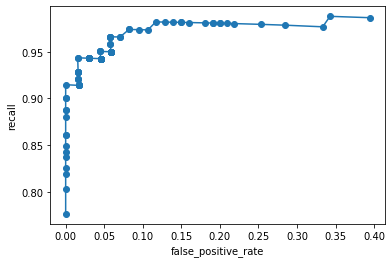

In [45]:
plt.plot(
    svc_classifier_linear_false_positive_rate_sweep,
    svc_classifier_linear_recall_sweep,
    "-o"   
)
plt.ylabel("recall")
plt.xlabel("false_positive_rate")

sklearn nos provee de una función que automáticamente nos grafica la curva ROC y nos calcula el área bajo la curva. Podemos ver que el modelo que retorna valores al azar tiene un valor de área bajo la curva de 0.5, que por definición siempre se asocia a un estimador a

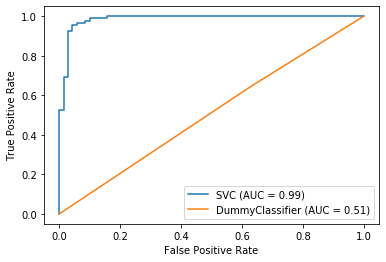

In [46]:
svc_roc_curve = sklearn.metrics.plot_roc_curve(
    svc_classifier_linear,
    features_test,
    label_test
)
rfc_disp = sklearn.metrics.plot_roc_curve(
    dummy_classifier,
    features_test,
    label_test,
    ax=svc_roc_curve.ax_
)